In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import nibabel as nib

from scipy import ndimage
from skimage import measure

def view_image_data(img_data, x_mid=None, y_mid=None, z_mid=None, smooth=None, cmap_mode=None, roi_mask=None, contour_color='white'):

    # We assume the 3D image data is in the first 3 dimensions if it is a 4D tensor
    if len(img_data.shape) in (3, 4):
        if len(img_data.shape) == 4:
            img_data = img_data.squeeze(dim=0)
        # Transpose to X, Y, Z axis
        img_data = img_data.permute(2, 1, 0)
        
        roi_processed = None
        if roi_mask is not None:
            if len(roi_mask.shape) == 4:
                roi_mask = roi_mask.squeeze(dim=0)
            roi_processed = roi_mask.permute(2, 1, 0)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        cmap_mode = 'gray' if cmap_mode is None else cmap_mode
        
        # Get middle slices by default
        x_mid = (img_data.shape[0]) // 2 if x_mid is None else x_mid
        y_mid = (img_data.shape[1]) // 2 if y_mid is None else y_mid
        z_mid = (img_data.shape[2]) // 2 if z_mid is None else z_mid
        
        sagittal_slice = img_data[x_mid, :, :].cpu().numpy() if torch.is_tensor(img_data) else img_data[x_mid, :, :]
        coronal_slice = img_data[:, y_mid, :].cpu().numpy() if torch.is_tensor(img_data) else img_data[:, y_mid, :]
        axial_slice = img_data[:, :, z_mid].cpu().numpy() if torch.is_tensor(img_data) else img_data[:, :, z_mid]
        
        roi_slices = [None, None, None]
        if roi_processed is not None:
            roi_sagittal = roi_processed[x_mid, :, :].cpu().numpy() if torch.is_tensor(roi_processed) else roi_processed[x_mid, :, :]
            roi_coronal = roi_processed[:, y_mid, :].cpu().numpy() if torch.is_tensor(roi_processed) else roi_processed[:, y_mid, :]
            roi_axial = roi_processed[:, :, z_mid].cpu().numpy() if torch.is_tensor(roi_processed) else roi_processed[:, :, z_mid]
            roi_slices = [roi_sagittal, roi_coronal, roi_axial]
        
        if smooth is not None:
            print(f"Applying Gaussian smoothing with radius={smooth}...")
            sagittal_slice = ndimage.gaussian_filter(sagittal_slice, smooth)
            coronal_slice = ndimage.gaussian_filter(coronal_slice, smooth)
            axial_slice = ndimage.gaussian_filter(axial_slice, smooth)

        slices = [sagittal_slice, coronal_slice, axial_slice]
        slice_names = ['Sagittal', 'Coronal', 'Axial']
        slice_coords = [x_mid, y_mid, z_mid]
        coord_labels = ['X', 'Y', 'Z']
        
        for i, (slice_data, roi_slice, name, coord, coord_label) in enumerate(zip(slices, roi_slices, slice_names, slice_coords, coord_labels)):
            im = axes[i].imshow(np.rot90(slice_data), cmap=cmap_mode, aspect='auto')
            
            if roi_slice is not None:
                try:
                    contours = measure.find_contours(np.rot90(roi_slice), 0.5)
                    for contour in contours:
                        axes[i].plot(contour[:, 1], contour[:, 0], color=contour_color, linewidth=1.5)
                except:
                    print(f"Warning: Could not generate contours for {name} slice")
            
            axes[i].set_title(f'{name} Slice ({coord_label}={coord})')
            axes[i].axis('off')
            
        
        plt.tight_layout()
    else:
        print("Image is not 3D. Shape:", img_data.shape)
    

Mask volume shape: (1, 91, 109, 91)
Applying Gaussian smoothing with radius=2.0...


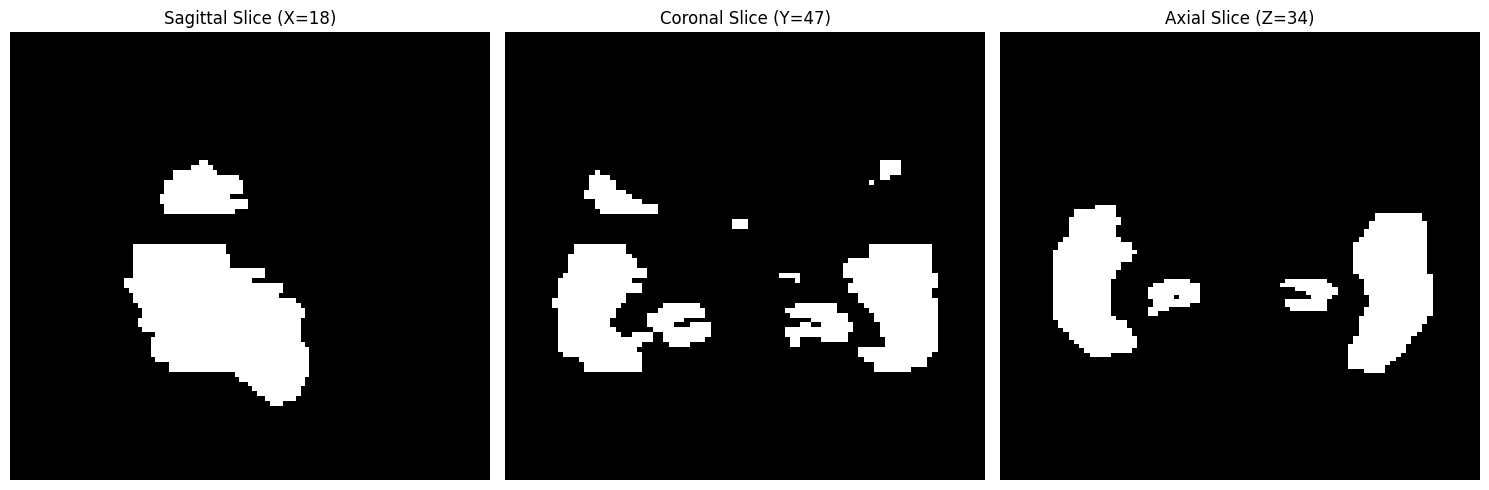

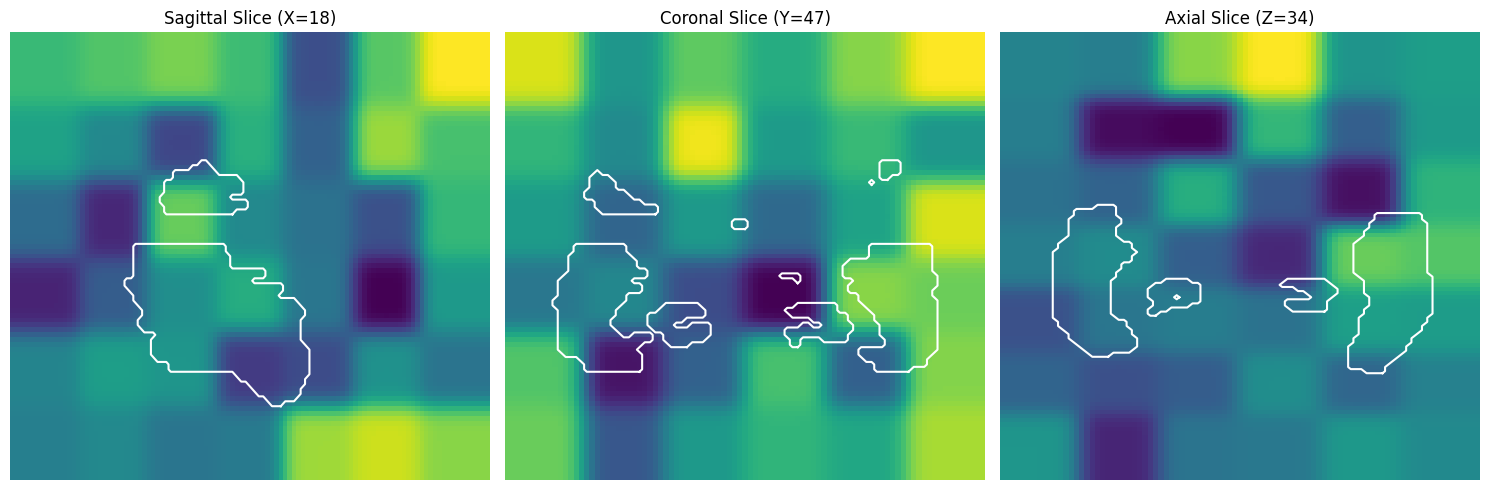

In [394]:
mask_path = Path("/home/diogommiranda/tese/masks/ROI_MASK.nii")
mask_img = nib.load(mask_path)
mask_volume = mask_img.get_fdata(dtype=np.float32)
#padding = ((2,3), (1,2), (2,3))
#mask_volume = np.pad(mask_volume, padding, mode='edge')
mask_volume = np.expand_dims(mask_volume, axis=0)
mask_volume = np.transpose(mask_volume, (0, 3, 2, 1)) # Transpose to (depth, height, width)
print(f"Mask volume shape: {mask_volume.shape}")
mask_volume = torch.tensor(mask_volume, dtype=torch.float32)

# 0-15, 16-31, 32-47, 48-63, 64-79, 80-95, 96-111
x_mid, y_mid, z_mid = 18, 47, 34
view_image_data(mask_volume, x_mid=x_mid, y_mid=y_mid, z_mid=z_mid)

path = "/home/diogommiranda/tese/mapas/hybrid_no_guidance/train_att_volume.pt"
this = torch.load(path)
view_image_data(this, x_mid=x_mid, y_mid=y_mid, z_mid=z_mid, smooth=2.0, cmap_mode='viridis', roi_mask=mask_volume, contour_color='white')